In [1]:
from fastai import *
from fastai.vision.all import *
from IPython.display import clear_output, DisplayHandle
import cv2 
# from numba import cuda

print(f'GPU is available: {torch.cuda.is_available()}')


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch
# clear the GPU cache
# torch.cuda.empty_cache()

GPU is available: True


In [2]:

# need to load these functions because they are associated with the learner
def get_mask_file(image_file, p2c):
    # this is the base path
    base_path = image_file.parent.parent.parent
    # get training or testing from here
    first_name = re.findall(string=image_file.name, pattern=r"^[training|testing|]*")[0]
    # get the sample number
    nums = re.findall(string=image_file.name, pattern=r"\d+_\d+_\d+")[0]  # remove from list
    # put the whole thing together
    str_name = f'{first_name}_groundtruth_' + nums + image_file.suffix
    # attach it to the correct path
    mask_path = (base_path / first_name / 'masks' / str_name)
    # convert to an array (mask)
    msk = np.array(PILMask.create(mask_path))
    mx = np.max(msk)
    # find all the possible values in the mask (0,255)
    for i, val in enumerate(p2c):
        msk[msk == p2c[i]] = val
    return PILMask.create(msk)

def get_y(o):
    return get_mask_file(o, p2c)

# load the model
project_directory = Path.cwd().joinpath('../')
fname = f"mito_dynamic_unet_seg_model-e50_b16.pkl"
print(fname)
output_file = project_directory.joinpath(Path("segmentation_model_dir").joinpath(fname))

# now we need to fine tune this model on the glom dataset
segmentation_model = load_learner(output_file)


dynamic_unet_seg_model-e50_b16.pkl


In [3]:
# load up the data
def get_all_paths(directory_path):
    directory = Path(directory_path)
    paths = []
    for path in directory.glob('**/*'):
        if path.is_file():
            paths.append(path)
    return paths


train_mask_path = project_directory.joinpath('data/Lauren_PreEclampsia_Data/train/masks')
glom_mask_files = get_all_paths(train_mask_path)
print(len(glom_mask_files))

train_image_path = project_directory.joinpath('data/Lauren_PreEclampsia_Data/train/images')
glom_image_files = get_all_paths(train_image_path)
print(len(glom_image_files))

assert(len(glom_image_files) <= len(glom_mask_files))


88
84


In [4]:
# new addition is thresh, since for whatever reason my binary mask has pixel values in between 0 and 1
def n_glom_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`, full file paths"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

p2c = n_glom_codes(glom_mask_files)
print(p2c)


def get_glom_mask_file(image_file, p2c, thresh=127):
    # this is the base path
    base_path = image_file.parent.parent.parent
    # print(base_path)
    first_name = image_file.parent.name
    # print(first_name)
    # get training or testing from here
    full_name = re.findall(string=image_file.name, pattern=r"^[A-Za-z]*[0-9]+[_|-]+[A-Za-z]*[0-9]+")[0]
    # put the whole thing together
    str_name = f'{full_name}_mask' + image_file.suffix
    # attach it to the correct path
    mask_path = (base_path / 'masks' / first_name / str_name)
    
    # convert to an array (mask)
    msk = np.array(PILMask.create(mask_path))
    # convert the image to binary if it isn't already (tends to happen when working with .jpg files)
    msk[msk <= thresh] = 0
    msk[msk > thresh] = 1
    
    # find all the possible values in the mask (0,255)
    for i, val in enumerate(p2c):
        msk[msk == p2c[i]] = val
    return PILMask.create(msk)

def get_glom_y(o):
    return get_glom_mask_file(o, p2c)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 128, 10: 129, 11: 130, 12: 131, 13: 132, 14: 133, 15: 135, 16: 255, 17: 56, 18: 57, 19: 134, 20: 58, 21: 187, 22: 188, 23: 184, 24: 185, 25: 186, 26: 59, 27: 60, 28: 61, 29: 62, 30: 63, 31: 64, 32: 65, 33: 66, 34: 67, 35: 68, 36: 69, 37: 189, 38: 190, 39: 191, 40: 192, 41: 193, 42: 194, 43: 195, 44: 196, 45: 197, 46: 70, 47: 71, 48: 247, 49: 253, 50: 121, 51: 198, 52: 250, 53: 251, 54: 252, 55: 254, 56: 248, 57: 249, 58: 122, 59: 123, 60: 124, 61: 125, 62: 126, 63: 127}


Unique values in the mask: [0 1]
Unique values in the mask: [0 1]
Unique values in the mask: [0 1]
Unique values in the mask: [0 1]
Unique values in the mask: [0 1]


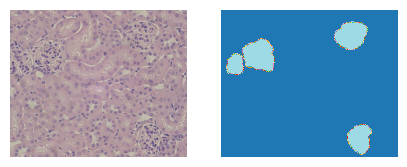

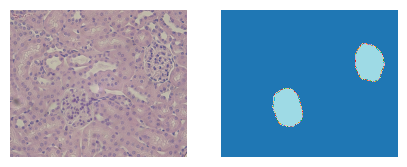

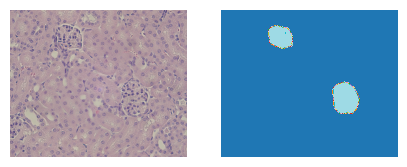

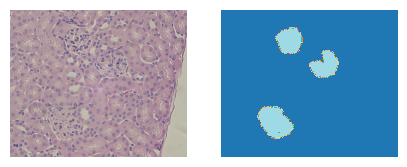

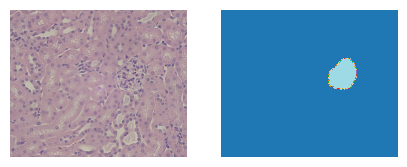

In [5]:
def show_mask(img_fn):
    img = PILImage.create(img_fn)
    msk = PILMask.create(get_glom_mask_file(img_fn, p2c))

    fig, ax = plt.subplots(1, 2, figsize=(5, 5))

    # Show image on left axis
    img.show(ax=ax[0])

    # Show mask on right axis
    msk.show(ax=ax[1], alpha=1)

    print(f"Unique values in the mask: {np.unique(np.array(msk))}")


# Show a few masks and their unique values
for image_path in glom_image_files[:5]:
    show_mask(image_path)


In [6]:
# for cutout implementation
from fastai.vision.augment import RandomErasing

# The RandomErasing class parameters are:
# p (float): Probability of applying the transformation.
# sl (float): Minimum proportion of erased area against input image.
# sh (float): Maximum proportion of erased area against input image.
# min_aspect (float): Minimum aspect ratio of erased area.
# max_count (int): Maximum number of erasing areas per image.

gpt_rec_batch_aug = [*aug_transforms(size=256,  # Increase the output image size
                               flip_vert=True,
                               max_rotate=45,
                               min_zoom=0.8,
                               max_zoom=1.3,
                               max_warp=0.4,
                               max_lighting=0.2),  # Add brightness and contrast adjustments
               RandomErasing(p=0.5, sl=0.01, sh=0.3, min_aspect=0.3, max_count=3)]

# my_batch_aug = [*aug_transforms(size=256,
#                           flip_vert=True,
#                           max_rotate=45,
#                           min_zoom=0.8,
#                           max_zoom=1.3,
#                           max_warp=0.4)]

gloms = DataBlock(blocks=(ImageBlock, MaskBlock(codes=np.array(['not_glom', 'glom']))),
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_items=lambda x: glom_image_files,
                  get_y=get_glom_y,  # get_mask_file,  # Use the custom getter function for masks
                  item_tfms=[RandomResizedCrop(512, min_scale=0.45)],  # this is super important - upscale the crop at each batch randomly
                  batch_tfms=gpt_rec_batch_aug,
                  n_inp=1,
                  )

batch_size = 16
glom_dls = gloms.dataloaders(glom_image_files,  bs=batch_size)
gloms.summary(glom_image_files, bs=batch_size)


Setting-up type transforms pipelines
Found 84 items
2 datasets of sizes 68,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_glom_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/Lauren_PreEclampsia_Data/train/images/T29/T29_Image0.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=2448x2048
  Pipeline: get_glom_y -> PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/Lauren_PreEclampsia_Data/train/images/T29/T29_Image0.jpg
    applying get_glom_y gives
      PILMask mode=L size=2448x2048
    applying PILBase.create gives
      PILMask mode=L size=2448x2048

Final sample: (PILImage mode=RGB size=2448x2048, PILMask mode=L size=2448x2048)


Found 84 items
2 datasets of sizes 68,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_glom_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCo

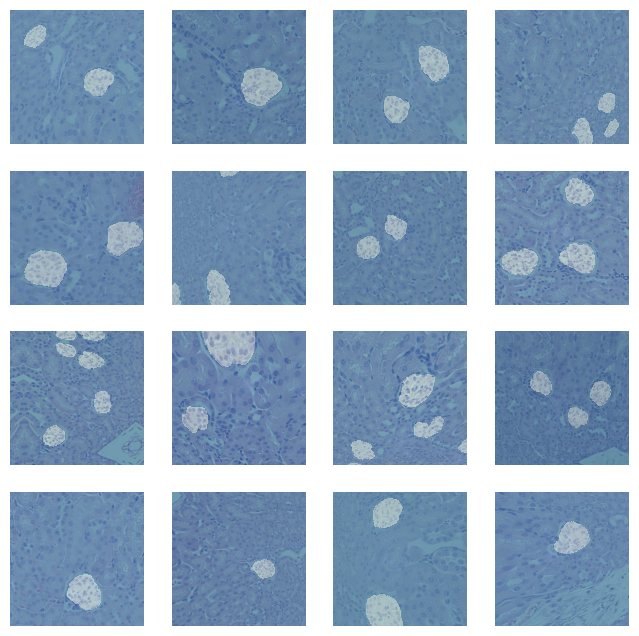

In [7]:
glom_dls.show_batch(max_n=batch_size, vmin=0, vmax=1, figsize=(batch_size/2,batch_size/2))

In [8]:
segmentation_model.dls = glom_dls


## Differences between fit, fine_tune, and fit_one_cycle calls

1. `fit`: This function is used for basic training of a model for a specified number of epochs with a constant learning rate. It updates the model weights using the given learning rate throughout the training process. You should use fit when you want to have a constant learning rate during training, and you don't need any advanced scheduling or fine-tuning techniques.

2. `fine_tune`: This function is specifically designed for transfer learning. It first trains the randomly initialized head of the model for one epoch (by default) with a high learning rate and then trains the entire model for the specified number of epochs using a lower learning rate. This process allows the model to adapt to the new dataset while preserving the pre-trained features. You should use fine_tune when you want to leverage a pre-trained model and adapt it to a new dataset.

3. `fit_one_cycle`: This function implements the 1cycle policy, which is a training method that uses a cyclical learning rate and momentum schedule. It starts with a low learning rate, gradually increases it to a maximum value, and then decreases it again. This method helps in faster convergence and better performance. You should use fit_one_cycle when you want a more sophisticated learning rate schedule to potentially improve training efficiency.

In [9]:
# Freeze the model except the last layer(s)
segmentation_model.freeze()

# Note: If you don't freeze the model before training, you'll update the weights of all layers during training right from the beginning. 
# This means that the pre-trained knowledge stored in the earlier layers of the model might be altered too quickly, which can degrade the 
# model's performance.


(0.00043651582673192023,
 0.005248074419796467,
 0.0002754228771664202,
 0.0005754399462603033)

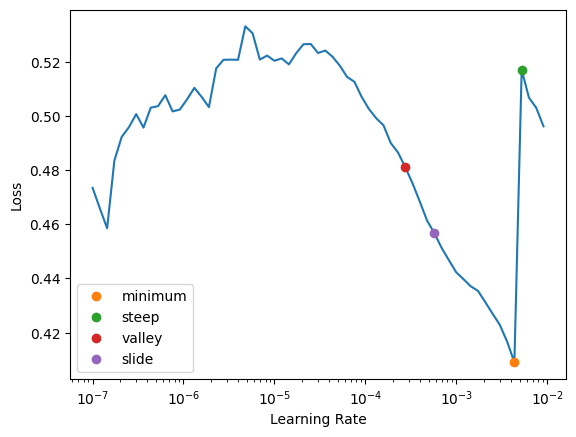

In [10]:
# # find a good learning rate
lr_min, lr_steep, lr_valley, lr_slide = segmentation_model.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide


In [11]:
# Train the last layer(s) using fit_one_cycle
n_epochs_head = 15
lr_max_head = lr_min  # Adjust this value as needed
segmentation_model.fit_one_cycle(n_epochs_head, lr_max_head,
                                 cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
                                      SaveModelCallback(monitor='valid_loss', fname='best_model')])

# Note: When you freeze the model except for the last layer(s), you essentially keep the weights of the pre-trained layers fixed while 
# training only the newly added layer(s) to adapt to the new dataset. This helps the new layer(s) learn the task-specific features without 
# affecting the pre-trained knowledge in the earlier layers.

epoch,train_loss,valid_loss,dice,time
0,0.501609,0.275541,0.001093,00:06
1,0.534817,0.266826,0.054543,00:06
2,0.508137,0.274191,0.089399,00:06
3,0.476048,0.298030,0.133991,00:06
4,0.437106,0.275417,0.163376,00:06
5,0.401953,0.264959,0.162396,00:06
6,0.374523,0.227913,0.245806,00:06
7,0.349570,0.192465,0.339641,00:06
8,0.329731,0.171559,0.402164,00:06
9,0.306681,0.145977,0.485241,00:06


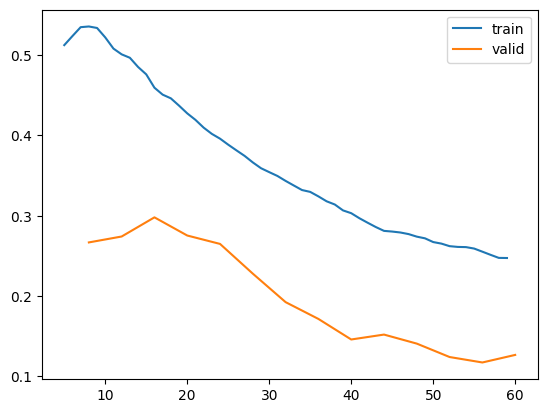

In [12]:
segmentation_model.recorder.plot_loss()


In [13]:
# Unfreeze the entire model
segmentation_model.unfreeze()

# Note: After the last layer(s) have been trained, you can then unfreeze the entire model and train it with a *lower* learning rate. 
# This way, you're fine-tuning the entire model to the new dataset, making small adjustments to the pre-trained layers to further 
# improve performance.


(0.00043651582673192023,
 6.309573450380412e-07,
 0.0003311311302240938,
 0.0010000000474974513)

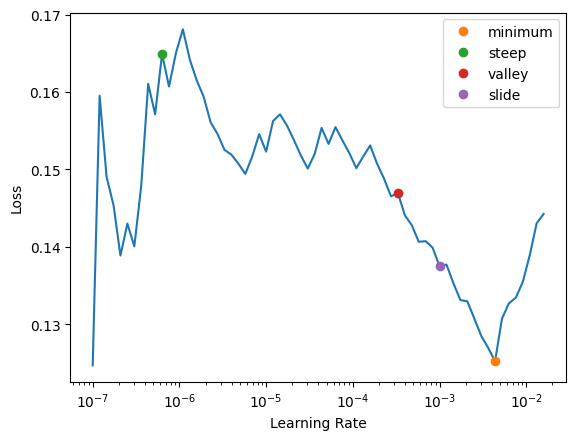

In [14]:
# # find a good learning rate
lr_min, lr_steep, lr_valley, lr_slide = segmentation_model.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide


In [15]:
n_epochs = 50
# based off of multiple runs of find_lr(), taking the valley
my_lr_max = 5e-4
my_cbs = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=5),
          SaveModelCallback(monitor='valid_loss', fname='best_model')]

# my_cbs = SaveModelCallback(monitor='valid_loss', fname='best_model')
segmentation_model.fit_one_cycle(n_epochs, my_lr_max, 
                                 cbs=my_cbs)


epoch,train_loss,valid_loss,dice,time
0,0.147686,0.127753,0.621773,00:06
1,0.138877,0.129505,0.591263,00:07
2,0.151874,0.121010,0.640023,00:06
3,0.155589,0.103278,0.741263,00:06
4,0.152514,0.096364,0.802739,00:07
5,0.154990,0.092357,0.821336,00:06
6,0.141747,0.084358,0.785709,00:06
7,0.135439,0.076927,0.808979,00:07
8,0.130585,0.083079,0.793635,00:06
9,0.126869,0.072723,0.820207,00:06


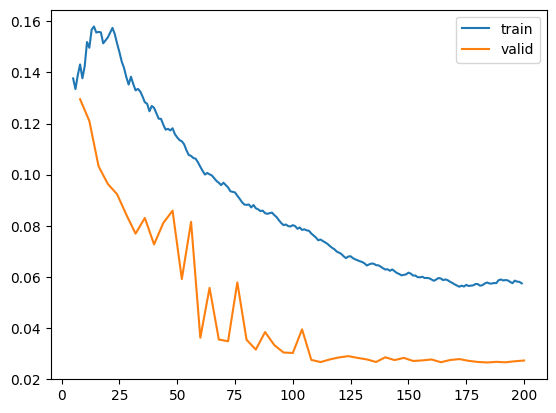

In [16]:
segmentation_model.recorder.plot_loss()


In [17]:
rec_vals = segmentation_model.recorder.values[-1]
print(len(rec_vals))
print(f'Training loss: {rec_vals[0]}')
print(f'Validation loss: {rec_vals[1]}')
print(f'Dice Coef: {rec_vals[2]}')


3
Training loss: 0.057480111718177795
Validation loss: 0.02731427177786827
Dice Coef: 0.9166640869269108


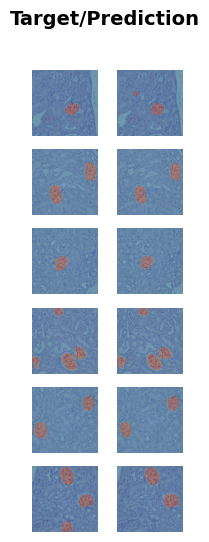

In [18]:
segmentation_model.show_results(max_n=6,figsize=(2,6))

In [21]:
# save the model
os.makedirs("../segmentation_model_dir", exist_ok=True)
fname = f"glomerulus_segmentation_model-dynamic_unet-e{n_epochs}_b{batch_size}_s{len(glom_image_files)}.pkl"
print(fname)

output_file = project_directory.joinpath(Path("segmentation_model_dir").joinpath(fname))

# saves the whole model, not just the weights
segmentation_model.export(output_file)


glomerulus_segmentation_model-dynamic_unet-e50_b16_s84.pkl


: 